In [53]:
import sys
import scipy.io
import numpy as np
sys.path.append('../src')
import pandas as pd
import matplotlib.pyplot as plt
from mvt_brr import MVTModel

In [41]:
data = scipy.io.loadmat('../leheron_trialbytrial/leheron_blockSwitchIndex.mat')
block_order_df = pd.read_csv('../leheron_trialbytrial/leheron_blockOrder.csv')
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")

In [13]:
block_switch_index = data['blockSwitchIndex']
n_subjects = block_switch_index.shape[1]

In [36]:
block_order_df.iloc[0,]

1    1
2    2
Name: 0, dtype: int64

In [55]:
# for i in range(n_subjects):
#     # Access the i-th subject's data, which is in the form of a 2D array
#     subject_data = block_switch_index[0, i]
    
#     # Flatten the subject data array to 1D if needed
#     subject_data = subject_data.flatten()
    
#     print(f"Subject {i+1}:\nTrial length: {len(subject_data)}")
#     # print(subject_data)
#     block_switches = np.where(subject_data == 1)[0]  # Find indices where block switches occur (value is 1)
#     if block_order_df.iloc[0, 0] == 1:
#         print(f"Rich->Poor at {block_switches[-1]+1} timestep")
#     else:
#         print(f"Poor->Rich at {block_switches[-1]+1} timestep")

23 July

In [43]:
df_trials.head(5)

,sub,patch,env,leaveT,meanLT,dmLeave
0,1,3,1,45.034784,40.532927,4.501856
1,1,2,1,44.403900,40.532927,3.870973
2,1,3,1,61.168672,40.532927,20.635745
3,1,1,1,26.803514,40.532927,-13.729413
4,1,3,1,56.992002,40.532927,16.459075


In [45]:
grouped_df = df_trials.groupby(['env', 'patch']).agg(
    mean_leaveT=('leaveT','mean'),
    sd_leaveT=('leaveT', 'std')
).reset_index()

print(grouped_df)

   env  patch  mean_leaveT  sd_leaveT
0    1      1    11.137706   6.020383
1    1      2    15.051354   6.435201
2    1      3    19.709716   7.450578
3    2      1    14.309812   6.639575
4    2      2    18.947625   7.008822
5    2      3    23.441306   7.471792


In [57]:
model = MVTModel(decay_type='exponential')
MVT_rich, MVT_poor = model.run()

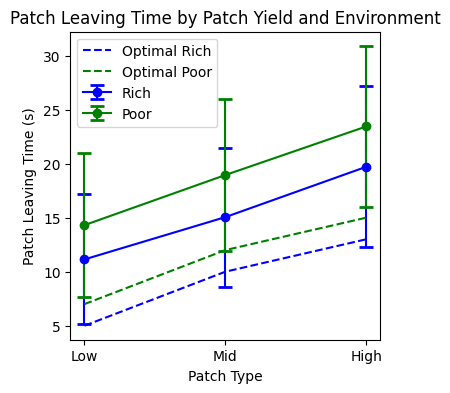

In [61]:
envs = grouped_df['env'].unique()

colors = {1: 'blue', 2: 'green'}
labels = {1: 'Rich', 2:'Poor'}

plt.figure(figsize=(4, 4))

for env in envs:
    env_data = grouped_df[grouped_df['env']==env]

    plt.errorbar(
        env_data['patch'],
        env_data['mean_leaveT'],
        yerr=env_data['sd_leaveT'],
        fmt='o-',
        capsize = 5,
        capthick = 2,
        color = colors[env],
        label = labels[env]
    )
plt.plot([1, 2, 3], MVT_rich, 'b--', label='Optimal Rich')
plt.plot([1, 2, 3], MVT_poor, 'g--', label='Optimal Poor')
plt.xticks([1, 2, 3], ['Low', "Mid", "High"])

plt.xlabel('Patch Type')
plt.ylabel('Patch Leaving Time (s)')
plt.title('Patch Leaving Time by Patch Yield and Environment')
plt.legend()
# plt.legend(title='Subjects')

plt.show()